In [1]:
# 连接Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import math, copy, time
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.sparse as sparse
from torch import linalg as LA
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import coo_matrix
# %matplotlib inline

# Device and random seed settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 996
np.random.seed(SEED)
torch.manual_seed(SEED)
if device=="cuda":
  torch.cuda.manual_seed(SEED)

cpu


In [3]:
# # hyper-parameters
# LR = 1e-3
# NODE_FEATURES = 10
# EMB_DIM = 128
# GCN_HIDDEN = 16
# GCN_DROP = 0
# WEIGHT_DECAY = 5e-4
EPOCHS = 100
# ngf = 16 # 这个再调吧 
n_blocks = 2
side_len = 32 # 不可以动，接近算力极限
seq_len = 24 # 不建议动，要与数据一致
batch_size = 4
testing_set_rate = 0.3
heads = 8
d_model = 64
ngf = d_model // 4

drive_prefix = "/content/drive/My Drive/"
corr_path_prefix = "/content/drive/My Drive/UrbanTrans/fine-gain-data/c_"
speed_path_prefix = "/content/drive/My Drive/UrbanTrans/fine-gain-data/s_"
nodes_features_path = "/content/drive/My Drive/UrbanTrans/fine-gain-data/nodes_features.npy"
model_out_path = drive_prefix + "UrbanTrans/Model/ours_candi_1.pkl"
data_date = 20121100 

In [4]:
# Data loading...

print("Data loading...")

corr_mat_seqs = []
speed_mat_seqs = []
for i in tqdm(range(1, 31)):
  corr_path = corr_path_prefix + str(data_date + i) + '.npy'
  speed_path = speed_path_prefix + str(data_date + i) + '.npy'
  corr_mat_seqs.append(np.load(corr_path))
  speed_mat_seqs.append(np.load(speed_path))


corr_mat_seqs = np.concatenate(corr_mat_seqs)
speed_mat_seqs = np.concatenate(speed_mat_seqs)


# 坏掉的全0的数据
corr_mat_seqs = np.delete(corr_mat_seqs, 575, 0)
speed_mat_seqs = np.delete(speed_mat_seqs, 575, 0)

# 规范化阈值
speed_mat_seqs[speed_mat_seqs>70] = 70
speed_mat_seqs[speed_mat_seqs==0] = 70

nodes_features = np.load(nodes_features_path)

print("corr shape:", corr_mat_seqs.shape, "speed shape:", speed_mat_seqs.shape, \
      "nodes features shape:", nodes_features.shape)
print("corr size:", corr_mat_seqs.nbytes, "speed size:", speed_mat_seqs.nbytes, \
      "nodes features size:", nodes_features.nbytes)

# 归一化
nodes_features = normalize(nodes_features, axis=0, norm='max')
corr_mat_seqs = corr_mat_seqs / corr_mat_seqs.max()
speed_mat_seqs = speed_mat_seqs / speed_mat_seqs.max()

  0%|          | 0/30 [00:00<?, ?it/s]

Data loading...


100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


corr shape: (718, 1024, 1024) speed shape: (718, 32, 32) nodes features shape: (1024, 148)
corr size: 6023020544 speed size: 5881856 nodes features size: 1212416


In [5]:
class UrbanDataset(Dataset):
  """Urban dataset"""

  def __init__(self, corr_mat, speed_mat):
    """
    Construct a model from hyperparameters.
    
    Parameters:
     corr_mat - (np.array) (seq_len, side_len**2, side_len**2)
     speed_mat - (np.array) (seq_len, side_len, side_len)
     
    Returns:
     Urban dataset.
 
    Raises:
     None, todo
    """
    self.corr_mat = torch.from_numpy(corr_mat)
    self.speed_mat = torch.from_numpy(speed_mat)

  def __len__(self):
    return len(self.corr_mat) // 24

  def __getitem__(self, idx):
    corr_seq = self.corr_mat[idx*24 : idx*24+24]
    speed_seq = self.speed_mat[idx*24 : idx*24+24]

    return corr_seq, speed_seq  

class UrbanSparseDataset(Dataset):
  """
  Urban sparse dataset
  """

training_set_size = int(len(corr_mat_seqs) * (1 - testing_set_rate))
testing_set_size = len(corr_mat_seqs) - training_set_size
urban_testing_set = UrbanDataset(corr_mat_seqs[training_set_size:], speed_mat_seqs[training_set_size:])
test_dataloader = DataLoader(urban_testing_set, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

In [6]:
def clones(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

# Hinton的论文
class LayerNorm(nn.Module):
  "Construct a layernorm module (See citation for details)."
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [7]:
# GAT for weights shared batch training
class GATConv(nn.Module):
  """
  Simple PyTorch Implementation of the Graph Attention layer.
  """
  # https://dsgiitr.com/blogs/gat/

  def __init__(self, in_features, out_features, heads, alpha=0.2, dropout=0.6 ,batch_size=4, seq_len=24, concat=True):
    super(GATConv, self).__init__()
    self.in_features = in_features     
    self.out_features = out_features     
    self.concat = concat # conacat = True for all layers except the output layer.
    self.heads = heads 
    self.batch_size = batch_size
    self.seq_len = seq_len

    # Xavier Initialization of Weights
    # Alternatively use weights_init to apply weights of choice 
    self.W = nn.Parameter(torch.Tensor(in_features, heads * out_features))
    # nn.init.xavier_uniform_(self.W.data, gain=1.414)
    self.a = nn.ParameterList([nn.Parameter(torch.Tensor(2 * out_features, 1)) for _ in range(heads)])
    # nn.init.xavier_uniform_(self.a.data, gain=1.414)

    # LeakyReLU
    self.leakyrelu = nn.LeakyReLU(alpha)
    self.softmax =  nn.Softmax(dim=-1)
    self.elu = nn.ELU()
    self.dropout = nn.Dropout(dropout) # drop prob = 0.6


  def forward(self, input, adj):
    print("input size:", input.size(), "adj size:", adj.size(), "W size", self.W.size())
    # (nodes_num, feature_dim), (batch_size, seq_len, side_len**2, side_len**2)
    # Linear Transformation
    N = input.size(1) # node_num = side_len**2

    x = torch.matmul(input, self.W) # => (batch_size x nodes_num x out_features*heads)
    print("1",x.size())

    x = x.view(-1, N, self.heads, self.out_features) # => (batch_size x nodes_num x self.heads x out_features)
    print("2",x.size())

    x = x.permute(2, 0, 1, 3) # => (heads x batch_size x nodes_num x out_features)
    print("3",x.size())
    # Attention Mechanism
    attn = []
    zero_vec  = -9e15 * torch.ones(N, N).to(device)

    for i, a in zip(x, self.a):
      for idx, j in enumerate(i):
        print(idx)
        attn_r = torch.cat([j.view(N,1,self.out_features).expand(N,N,self.out_features).reshape(N*N, self.out_features),
                            j.view(1,N,self.out_features).expand(N,N,self.out_features).reshape(N*N, self.out_features)], 
                           dim=-1).view(N,N,2*self.out_features)
        # attn_in = torch.cat([j.expand(-1, self.out_features*N).view(N*N, self.out_features), j.expand(N*N,1)], dim=-1).view(N,N,2*self.out_features)
        # => (N x N x 2*out_dim)
        attn_r = self.leakyrelu(torch.matmul(attn_r, a)).squeeze()
        # => (N x N)
        attn_r = torch.where(adj[idx] > 0, attn_r, zero_vec)
        attn_r = self.softmax(attn_r)
        attn_r = self.dropout(attn_r)
        attn.append(torch.matmul(attn_r, i)) # => (N, out_dim)
        del attn_r
                    
    x = torch.cat(attn, 0).reshape(self.heads, -1, N, self.out_features)
    # Average attention score

    x = torch.mean(x, 0)
    print("8", x.size())
    # => (batch_size x nodes_num x out_dim)
    if self.concat:
        return self.elu(x)
    else:
        return x
class GAT(nn.Module):
  def __init__(self, nfeat, nhid, nemb, dropout=0.6, batch_size=4, seq_len=24, heads=6):
    super(GAT, self).__init__()
    self.conv1 = GATConv(nfeat, nhid, heads=heads)
    self.conv2 = GATConv(nhid, nemb, heads=heads)
    self.dropout = nn.Dropout(dropout)
    self.elu = nn.ELU()

  def forward(self, x, adj):
    # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
    # One can skip them if the dataset is sufficiently large.

    # Transform x and adj to batch
    print("begin GAT")
    node_num = x.size(-2)
    feature_dim = x.size(-1)
    batch_size = adj.size(0)
    seq_len = adj.size(1)
    adj = adj.view(batch_size*seq_len, node_num, node_num) # => (batch_size x node_num x node_num)
    x = x.view(-1, node_num, feature_dim).expand(batch_size*seq_len, node_num, feature_dim) # => (batch_size (or 1) x node_num x feature_dim)
    print("x size",x.size(), "adj size", adj.size())

    x = self.dropout(x)

    x = self.elu(self.conv1(x, adj))
    x = self.dropout(x)
    x = self.conv1(x, adj)
    x = torch.reshape(x, (batch_size, seq_len, node_num, nemb))
    print("out size", x.size())
    return x

In [8]:
# GCN for multi-view embedding
class GraphConvolution(nn.Module):
  """
  Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
  """

  def __init__(self, in_features, out_features, bias=True):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
        self.bias = Parameter(torch.FloatTensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.matmul(input, self.weight)
    output = torch.matmul(adj, support)

    if self.bias is not None:
        return output + self.bias
    else:
        return output

  def __repr__(self):
    return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nemb, dropout, seq_len):
    super(GCN, self).__init__()

    self.gc1 = GraphConvolution(nfeat, nhid)
    self.gc2 = GraphConvolution(nhid, nemb)
    self.dropout = dropout

  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.gc2(x, adj)
    return x

# 这个就先不用了
# class MultiViewEmbed(nn.Module): 
#   def __init__(self, nemb, side_len, embeds, n_view): # N views
#     super(MultiViewEmbed, self).__init__()
# #         embed = GCN(nfeat, nhid, nemb, dropout, seq_len)
#     self.embeds = embeds
#     self.fc1 = nn.Linear(n_view*nemb, nemb)
#     self.fc2 = nn.Linear((side_len**2)*nemb, nemb)
#     self.relu = nn.ReLU(True)
      
#   def forward(self, input):
#     x, adjs = input[0], input[1]
#     embeddings = [emb(x, adj) for emb, adj in zip(self.embeds, adjs)]        
#     embeddings = torch.cat(embeddings,dim=-1)
#     embeddings = self.relu(self.fc1(embeddings))
#     embeddings = embeddings.contiguous().view(embeddings.size(0), embeddings.size(1), -1)
#     embeddings = self.relu(self.fc2(embeddings))
#     return embeddings

# 暂时使用这个
class SingleViewEmbed(nn.Module):   
  def __init__(self, nemb, side_len, embed):
    super(SingleViewEmbed, self).__init__()

    self.embed = embed
    self.fc = nn.Linear((side_len**2)*nemb, nemb)
    self.relu = nn.ReLU(True)
  
  def forward(self, input):
    x, adj = input[0], input[1]
    embedding = self.embed(x, adj)
    # -> (batch_size, seq_len, nodes(side_len*side_len), emb_dim)
    embedding = embedding.contiguous().view(embedding.size(0), embedding.size(1), -1)
    # -> (batch_size, seq_len, nodes*emb_dim)
    embedding = self.relu(self.fc(embedding))
    # -> (batch_size, seq_len, emb_dim)
    # 这一步将向量的维度压缩的太厉害了，是否可以考虑改进一下（CNN）
    return embedding


In [9]:
class SingleViewEmbedCNN(nn.Module):
  def __init__(self, nemb, side_len, embed):
    super(SingleViewEmbedCNN, self).__init__()

    self.embed = embed
    # 这个地方的channels维度是可以调的
    self.conv1 = nn.Conv2d(in_channels=nemb, out_channels=nemb, kernel_size=4, stride=2, padding=1, bias=False)        
    self.conv2 = nn.Conv2d(in_channels=nemb, out_channels=nemb, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(in_channels=nemb, out_channels=nemb, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(in_channels=nemb, out_channels=nemb, kernel_size=4, stride=1, padding=0)

    # self.bn1 = nn.BatchNorm2d(nemb)
    self.bn1 = nn.BatchNorm2d(nemb)
    self.bn2 = nn.BatchNorm2d(nemb)
    self.bn3 = nn.BatchNorm2d(nemb)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()
    self.side_len = side_len
  
  def forward(self, input):
    x, adj = input[0], input[1]
    embedding = self.embed(x, adj)

    batch_size = embedding.size(0)
    seq_len = embedding.size(1)

    # -> (batch_size, seq_len, nodes(side_len*side_len), emb_dim)
    embedding = embedding.contiguous().view(batch_size*seq_len, self.side_len, self.side_len, -1)
    embedding = embedding.permute(0, 3, 1, 2)  
    embedding = self.relu(self.conv1(embedding))
    # (batch_size*seq_len)
    # -> (nemb) x 16 x 16
    embedding = self.relu(self.bn1(self.conv2(embedding)))
    # -> (nemb) x 8 x 8
    embedding = self.relu(self.bn2(self.conv3(embedding)))
    # -> (nemb) x 4 x 4
    embedding = self.sigmoid(self.bn3(self.conv4(embedding)))
    # -> (nemb) x 1 x 1
    embedding = embedding.squeeze()
    # -> (batch_size*seq_len, nemb)
    embedding = embedding.view(batch_size, seq_len, -1)
    # -> (batch_size, seq_len, nemb)

    return embedding


In [10]:
# Upsampling for output target
class UpSampling(nn.Module):
  def __init__(self, nz, ngf):
    super(UpSampling, self).__init__()
    
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()
    
    self.convt1 = nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*4, kernel_size=4, stride=1, padding=0, bias=False)        
    self.convt2 = nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt3 = nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=1, kernel_size=4, stride=2, padding=1)

    self.bn1 = nn.BatchNorm2d(ngf*4)
    self.bn2 = nn.BatchNorm2d(ngf*2)
    self.bn3 = nn.BatchNorm2d(ngf)
  
  def forward(self, input):
    x = input.contiguous().view(input.size(0)*input.size(1), -1, 1, 1)
    # input nz
    x = self.relu(self.bn1(self.convt1(x)))
    # -> (ngf x 4) x 4 x 4
    x = self.relu(self.bn2(self.convt2(x)))
    # -> (ngf x 2) x 8 x 8
    x = self.relu(self.bn3(self.convt3(x)))
    # -> (ngf) x 16 x 16
    x = self.sigmoid(self.convt4(x))
    # -> (1) x 32 x 32
    return x

# Output => embedding
# 这部分讲道理也是应该要用卷积来做的
class OutputEmbed(nn.Module):
  def __init__(self,in_dim,hidden,out_dim):
    super(OutputEmbed, self).__init__()
    
    self.relu = nn.ReLU(True)
    
    self.fc1 = nn.Linear(in_dim, hidden)
    self.fc2 = nn.Linear(hidden, out_dim)

  def forward(self, x):
    x=x.contiguous().view(x.size(0), x.size(1), -1)
    return self.fc2(self.relu(self.fc1(x)))
      

In [11]:
class OutputEmbedCNN(nn.Module):
  def __init__(self,ngf):
    super(OutputEmbedCNN, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=ngf//2, kernel_size=4, stride=2, padding=1, bias=False)        
    self.conv2 = nn.Conv2d(in_channels=ngf//2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(in_channels=ngf, out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(in_channels=ngf*2, out_channels=ngf*4, kernel_size=4, stride=1, padding=0)

    self.bn1 = nn.BatchNorm2d(ngf)
    self.bn2 = nn.BatchNorm2d(ngf*2)
    self.bn3 = nn.BatchNorm2d(ngf*4)

    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    batch_size = x.size(0)
    seq_len = x.size(1)
    x = x.contiguous().view(x.size(0) * x.size(1), 1, side_len, side_len)
    x = self.relu(self.conv1(x))
    # # -> (ngf / 2) x 16 x 16
    x = self.relu(self.bn1(self.conv2(x)))
    # # -> (ngf) x 8 x 8
    x = self.relu(self.bn2(self.conv3(x)))
    # # -> (ngf x 2) x 4 x 4
    x = self.sigmoid(self.bn3(self.conv4(x)))
    # # -> (ngf x 4) x 1 x 1
    x = x.squeeze()
    x = x.contiguous().view(batch_size, seq_len, -1)
    return x    
        
        
        # # -> (ngf / 2) x 16 x 16
    # x = self.relu(self.bn1(self.conv2(x)))
    # -> (ngf) x 8 x 8
    # x = self.relu(self.bn2(self.conv3(x)))
    # -> (ngf x 2) x 4 x 4
   

In [12]:
# Transformer for learning time dependent
class EncoderDecoder(nn.Module):
  """
  A standard Encoder-Decoder architecture. Base for this and many 
  other models.
  """
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator
      
  def forward(self, src, tgt, tgt_mask, src_mask=None,):
    "Take in and process masked src and target sequences."
    return self.decode(self.encode(src, src_mask), src_mask,
                        tgt, tgt_mask)
  
  def encode(self, src, src_mask):
    x = self.src_embed(src)
    return self.encoder(x, src_mask)
  
  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


class Encoder(nn.Module):
  "Core encoder is a stack of N layers"
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
      
  def forward(self, x, mask):
    "Pass the input (and mask) through each layer in turn."
    for layer in self.layers:
        x = layer(x, mask)
    return self.norm(x)
    
# 残差连接
class SublayerConnection(nn.Module):
  """
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply residual connection to any sublayer with the same size."
    return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
  "Encoder is made up of self-attn and feed forward (defined below)"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    # "Follow Figure 1 (left) for connections."
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)
    
class Decoder(nn.Module):
  "Generic N layer decoder with masking."
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
      
  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
        x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    "Follow Figure 1 (right) for connections."
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

def attention(query, key, value, mask=None, dropout=None):
  "Compute Scaled Dot Product Attention'"
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) \
                              / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim = -1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    "Take in model size and number of heads."
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    # We assume d_v always equals d_k
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
      
  def forward(self, query, key, value, mask=None):
    "Implements Figure 2"
    if mask is not None:
        # Same mask applied to all h heads.
        mask = mask.unsqueeze(1)
    nbatches = query.size(0)
    
    # 1) Do all the linear projections in batch from d_model => h x d_k 
    query, key, value = \
        [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
          for l, x in zip(self.linears, (query, key, value))]
    
    # 2) Apply attention on all the projected vectors in batch. 
    x, self.attn = attention(query, key, value, mask=mask, 
                              dropout=self.dropout)
    
    # 3) "Concat" using a view and apply a final linear. 
    x = x.transpose(1, 2).contiguous() \
          .view(nbatches, -1, self.h * self.d_k)
    return self.linears[-1](x)
    
    
# Connect each layer in encoder or decoder
class PositionwiseFeedForward(nn.Module):
  "Implements FFN equation."
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
# Encoding the time position and add to embedding
class PositionalEncoding(nn.Module):
  "Implement the PE function."
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    
    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                          -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], 
                      requires_grad=False)
    return self.dropout(x)

In [13]:
def make_model(n_features=32, side_len=16, hidden=512, n_blocks=2, seq_len=24, \
               d_model=128, d_ff=512, ngf=32, heads=8, dropout=0.1, views=1):
  """
  Construct a model from hyperparameters.
  
  Parameters:
    seq_len - (int) the length of sequence in the task (including start symbol)
    side_len - (int) The city is divided into grids with sides side_len
    n_features - (int) the dim of node features
    hidden - (int) GCN hidden dim
    d_model - (int) embedding dim at each time position
    d_ff - (int) hidden dim of position-wise feed forward network
    n_blocks - (int) number of block repeats in Encode and Decode
    heads - (int) number of attention heads
    dropout - (float) dropout rate
    
  Returns:
    Full model.

  Raises:
    None, todo
  """
  c = copy.deepcopy
  attn = MultiHeadedAttention(heads, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)

  if views > 1:
    embeds = nn.ModuleList([GCN(n_features, hidden, d_model, dropout, seq_len) for _ in range(views)])

    model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), n_blocks),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), n_blocks),
      nn.Sequential(MultiViewEmbed(d_model, side_len, embeds, views), c(position)),
      nn.Sequential(OutputEmbed(side_len**2,hidden, d_model),c(position)),
      UpSampling(d_model, ngf)
    ) 
  
  else:
    embed = GCN(n_features, hidden, d_model, dropout, seq_len)

    model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), n_blocks),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), n_blocks),
      nn.Sequential(SingleViewEmbed(d_model, side_len, embed), c(position)),
      # nn.Sequential(SingleViewEmbedCNN(d_model, side_len, embed), c(position)),
      # nn.Sequential(OutputEmbed(side_len**2,hidden, d_model),c(position)),
      nn.Sequential(OutputEmbedCNN(ngf),c(position)),
      UpSampling(d_model, ngf)
  ) 
  # todo GCN params
  
  # This was important from their code. 
  # Initialize parameters with Glorot / fan_avg.
  
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
          
  return model.to(device)

In [14]:
def loss_fn(X,Y):
    
  Xs = X.split(1, dim=0)
  Ys = Y.split(1, dim=0)
  F_norm = 0
  for x, y in zip(Xs, Ys):
    F_norm += LA.norm(x-y)
    # F_norm += (x-y).sum()
  # return F_norm 
  return F_norm / len(Xs)

mse = nn.MSELoss()

def RMSE(x, y):
  return torch.sqrt(mse(x, y))

def MAPE(x, y):
  return torch.abs((x - y) / y).mean() * 100
    
# class LossCompute:
#     "A simple loss compute and train function."
#     def __init__(self, generator, criterion, opt=None):
#         self.generator = generator
#         self.criterion = criterion
#         self.opt = opt
        
#     def __call__(self, x, y, norm=24*16):
#         x = self.generator(x)
# #         loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
# #                               y.contiguous().view(-1)) / norm
#         loss = self.criterion(x, y) / norm
#         loss.backward()
#         if self.opt is not None:
#             self.opt.step()
#             self.opt.optimizer.zero_grad()
#         return loss.item() * norm

In [15]:
# 修改multi-view
class Batch:
  "Object for holding a batch of data with mask during training."
  def __init__(self, srcs, trg=None):
    self.srcs = srcs
    self.src_mask = None
    if trg is not None:
        self.trg = trg

In [16]:
def batch_gen(X, dataloader, start_symbol=-1e9):
  """
  Generate random data for a urban status prediction task.

  Parameters:
    batch - (int) the size of batch
    nbatches - (int) the num of total batch
    seq_len - (int) the length of sequence in the task (including start symbol)
    side_len - (int) The city is divided into grids with sides side_len
    n_features - (int) the dim of node features
    start_symbol - (float) represents the beginning of a sequence

  Returns:
    A data iterator, create one batch each time

  Raises:
    None, todo
  """
  X = Variable(torch.from_numpy(X), requires_grad=False).float()
  for i_batch, (corr, speed) in enumerate(dataloader):
    corr[:, 0] = start_symbol
    speed[:, 0] = start_symbol
    
    src = Variable(corr, requires_grad=False).float()
    tgt = Variable(speed, requires_grad=False).float()
    yield copy.deepcopy(X), Batch(src, tgt)

In [17]:
def greedy_decode(model, src, src_mask, tgt, max_len):
  memory = model.encode(src, src_mask)
  ys = tgt[:, :12]
  for i in range(max_len):
    # print(i)
    out = model.decode(memory, src_mask, Variable(ys), Variable(subsequent_mask(ys.size(1))))
    next_hour = model.generator(out)
    next_hour = next_hour[-1].unsqueeze(0)
    ys = torch.cat([ys, next_hour], dim=1)
  return ys

In [18]:
model = make_model(n_features=148, side_len=32, n_blocks=n_blocks, heads=heads, d_model=d_model, hidden=2*d_model,ngf=ngf)
model.load_state_dict(torch.load(model_out_path))
test_iter = batch_gen(nodes_features, test_dataloader)
max_len = 12
rmse_losses = []
mape_losses = []
predicts = []
ground_truth = []
for x, batch in test_iter:
    model.eval()
    x = x.to(device) # => [1024, 148]
    adjs = batch.srcs.to(device) # => [1, 24, 1024, 1024]
    src = (x, adjs)
    trg = batch.trg.to(device) # => [1, 12, 32, 32]
    y_pred = greedy_decode(model, src, None, trg, max_len)
    y_pred = y_pred[:, -12:].squeeze()
    trg_y = trg[:, -12:].squeeze()
    rmse_loss = [RMSE(y_hat, y).item() for y_hat, y in zip(y_pred, trg_y)]
    mape_loss = [MAPE(y_hat, y).item() for y_hat, y in zip(y_pred, trg_y)]
    rmse_losses.append(rmse_loss)
    mape_losses.append(mape_loss)
    ground_truth.append(trg_y)
    predicts.append(y_pred)

rmse_losses = np.array(rmse_losses)
mape_losses = np.array(mape_losses)
print("RMSE", np.mean(rmse_losses, 0))
print("MAPE", np.mean(mape_losses, 0))

RMSE [0.1059642  0.10408851 0.10664433 0.10498912 0.10195654 0.12422498
 0.1319619  0.13513118 0.12303399 0.11658167 0.11625118 0.11486127]
MAPE [13.86012141 13.65642336 14.70854187 14.3970072  15.01025687 18.82282162
 21.35445001 21.23898612 18.06608486 15.83260176 16.75183413 16.12951925]


Day 0


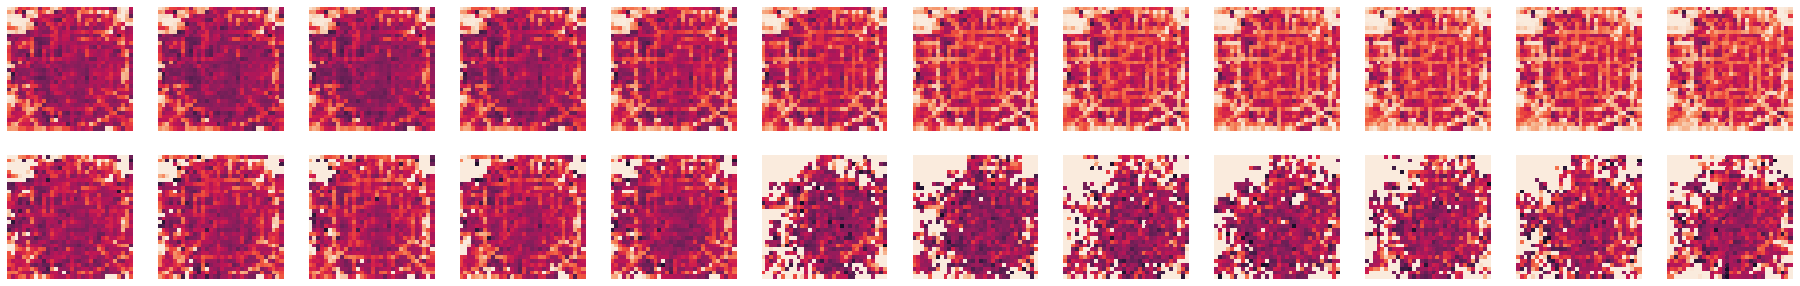

<Figure size 432x288 with 0 Axes>

Day 1


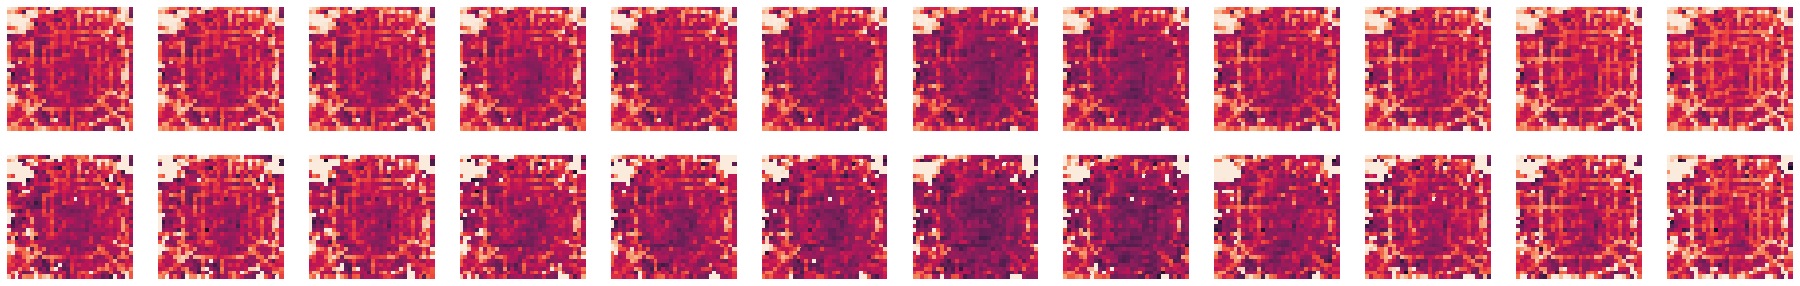

<Figure size 432x288 with 0 Axes>

Day 2


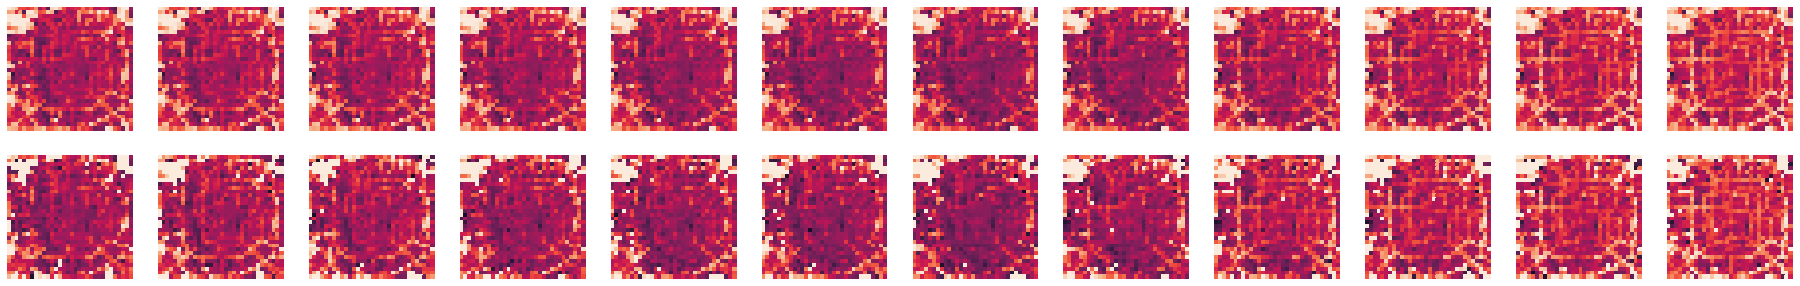

<Figure size 432x288 with 0 Axes>

Day 3


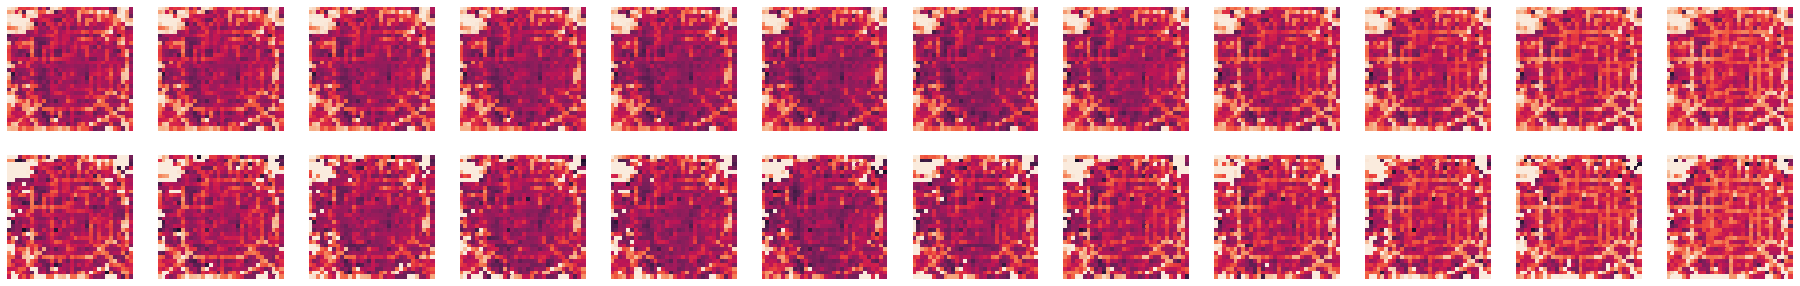

<Figure size 432x288 with 0 Axes>

Day 4


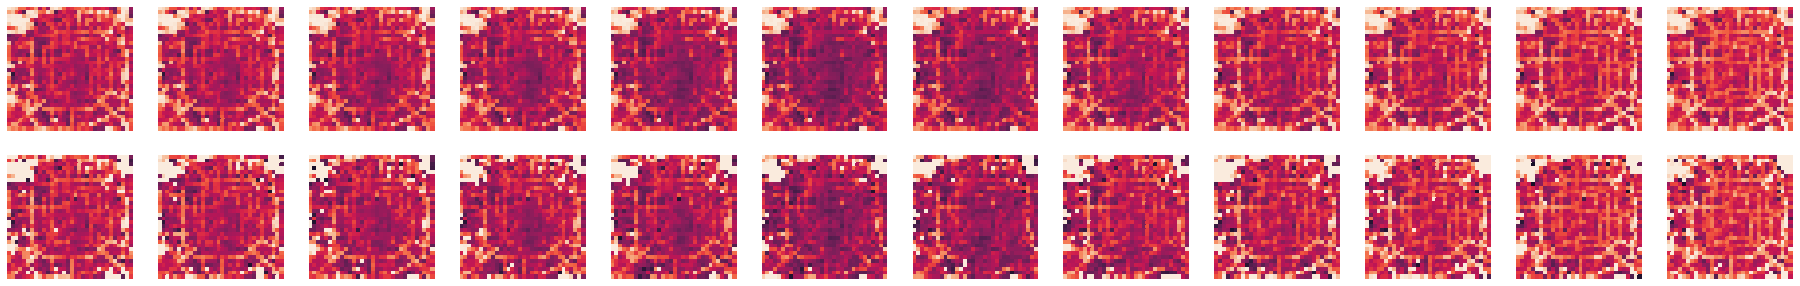

<Figure size 432x288 with 0 Axes>

Day 5


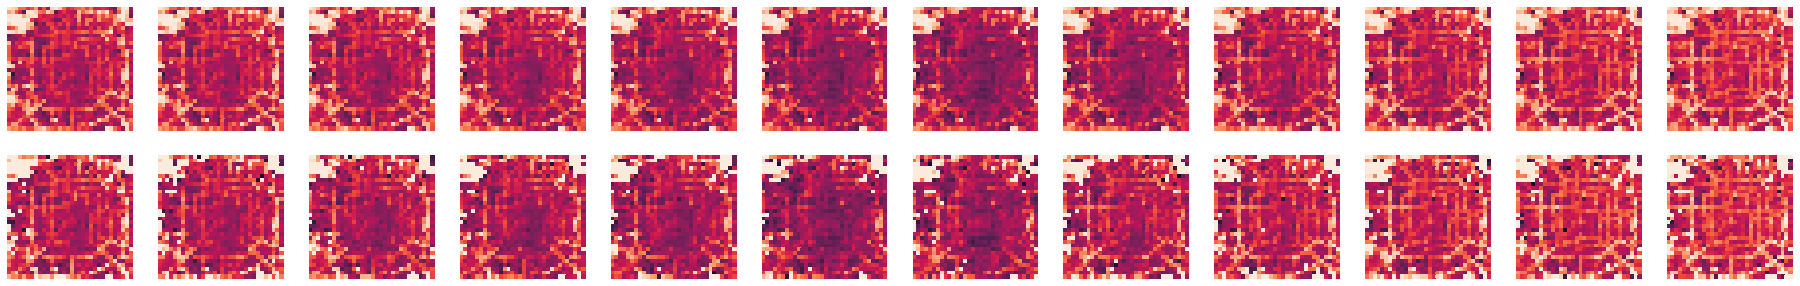

<Figure size 432x288 with 0 Axes>

Day 6


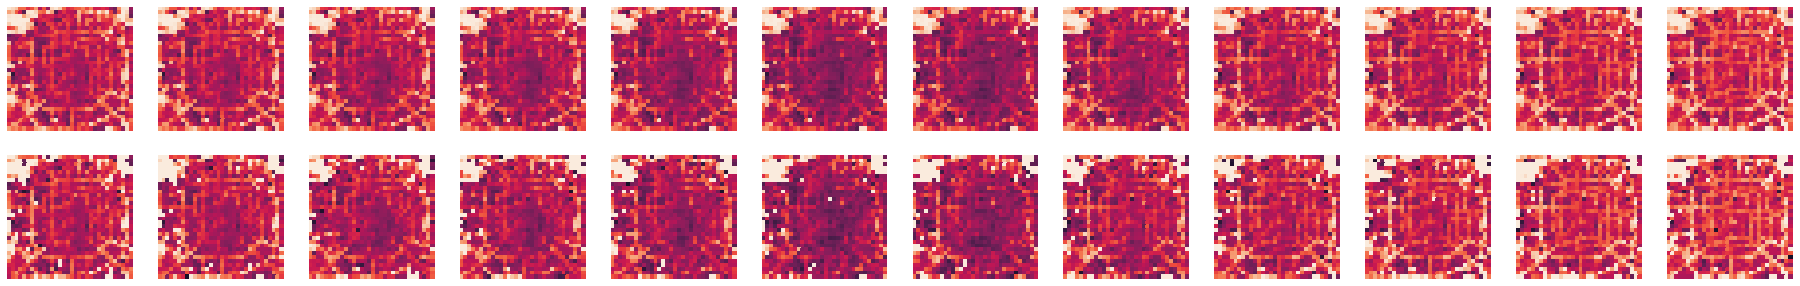

<Figure size 432x288 with 0 Axes>

Day 7


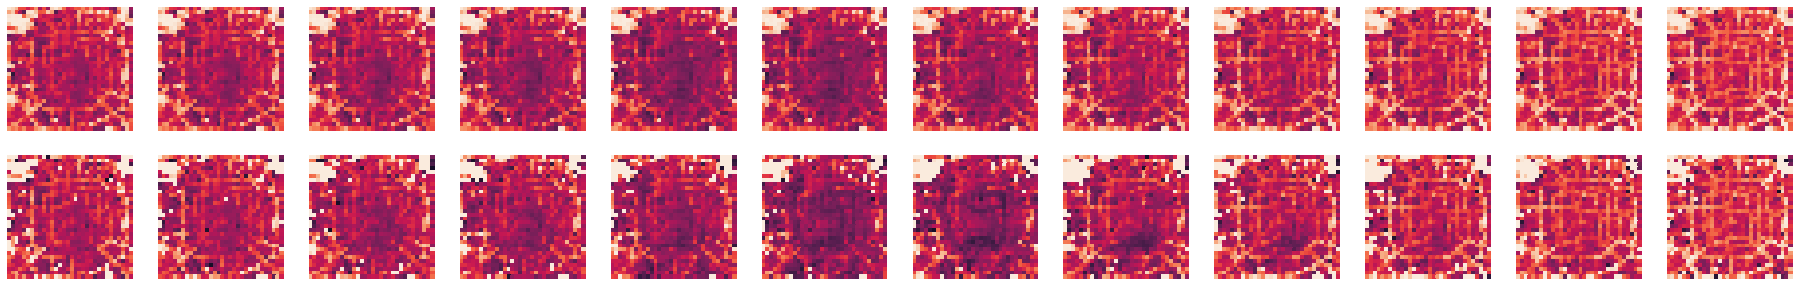

<Figure size 432x288 with 0 Axes>

Day 8


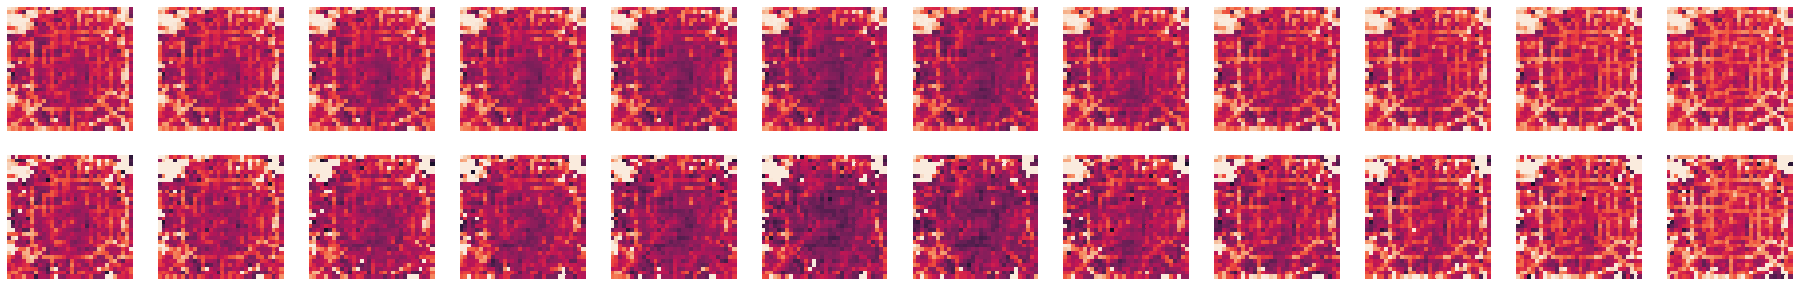

<Figure size 432x288 with 0 Axes>

In [21]:
# visualization
for i, (y_hat, truth) in enumerate(zip(predicts, ground_truth)):
  print("Day", i)
  y = truth.cpu() * 70
  y_hat = y_hat.detach().cpu() * 70
  fig, ax =plt.subplots(2,12,figsize=(32,5))
  plt.figure()

  for j, (y_hour, y_hat_hour) in enumerate(zip(y,y_hat)):
    sns.heatmap(y_hat_hour, ax=ax[0,j], vmin=0, vmax=70, xticklabels=False, yticklabels=False, cbar=False)
    sns.heatmap(y_hour, ax=ax[1,j], vmin=0, vmax=70, xticklabels=False, yticklabels=False,cbar=False)
  plt.show()